## Notebook to plot images for figure 1 for MICCAI submission

### create images of augmented data 






In [1]:
import os
import numpy as np
import nibabel as nb
import logging
from meld_graph.icospheres import IcoSpheres
import matplotlib_surface_plotting as msp
# import logging
logging.basicConfig(level=logging.DEBUG)

from meld_graph.augment import Augment
from meld_classifier.meld_cohort import MeldCohort
from meld_graph.dataset import GraphDataset

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


In [2]:
# create cmap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmp = cm.get_cmap('winter', 256)
newcolors = cmp(np.linspace(0, 1, 256))
grey = np.array([191/256, 191/256, 191/256, 1])
red = np.array([256/256, 0/256, 0/256, 1])
newcolors[0, :] = grey
newcolors[-1, :] = red
newcmp = ListedColormap(newcolors)

### Plot augmentation

In [3]:
#load a subject
subject = 'MELD_H4_3T_FCD_0011'
            # 'MELD_H4_3T_FCD_0009',
       
data_parameters = data_parameters = {
    "augment_data": {
    },
    "combine_hemis": None,
    "dataset": "MELD_dataset_V6.csv",
    "features": [
        '.combat.on_lh.w-g.pct.sm10.mgh'],
    "features_to_exclude": [],
    "features_to_replace_with_0": [],
    "fold_n": 0,
    "group": "control",
    "hdf5_file_root": "{site_code}_{group}_featurematrix_combat_6.hdf5",
    "icosphere_parameters": {"distance_type": "exact"},
    "lesion_bias": 0,
    "lobes": False,
    "number_of_folds": 5,
    "preprocessing_parameters": {
        "scaling": None,
        "zscore": "../data/feature_means.json",
    },
    "scanners": ["15T", "3T"],
    "site_codes": [
         "H4",
    ],
    "smooth_labels": True,
    "subject_features_to_exclude": [],
    "synthetic_data": {
        "bias": 1,
        "jitter_factor": 2,
        "n_subs": 1,
        "n_subtypes": 1,
        "proportion_features_abnormal": 0.9,
        "proportion_hemispheres_lesional": 0.5,
        "radius": 2,
        "run_synthetic": False,
        "smooth_lesion": False,
        "use_controls": True,
    },
}
cohort = MeldCohort(
            hdf5_file_root=data_parameters["hdf5_file_root"], dataset=data_parameters["dataset"]
        )
dataset = GraphDataset([subject], cohort, data_parameters, mode='test' , distance_maps=True)

features_subj = dataset.data_list[0]['features'][:,0] 
labels_subj =  dataset.data_list[0]['labels'] 
labels_smooth_subj =  dataset.data_list[0]['smooth_labels'] 
distance_subj = dataset.data_list[0]['distances'] 


DEBUG:meld_graph.icospheres:Using coord type pseudo
INFO:meld_graph.dataset:Loading and preprocessing test data
DEBUG:meld_graph.dataset:Combine hemis None


dataset using distance_maps


INFO:meld_graph.data_preprocessing:Z-scoring data for MELD_H4_3T_FCD_0011
DEBUG:meld_classifier.meld_cohort:missing feature: .on_lh.lesion.mgh set to zero


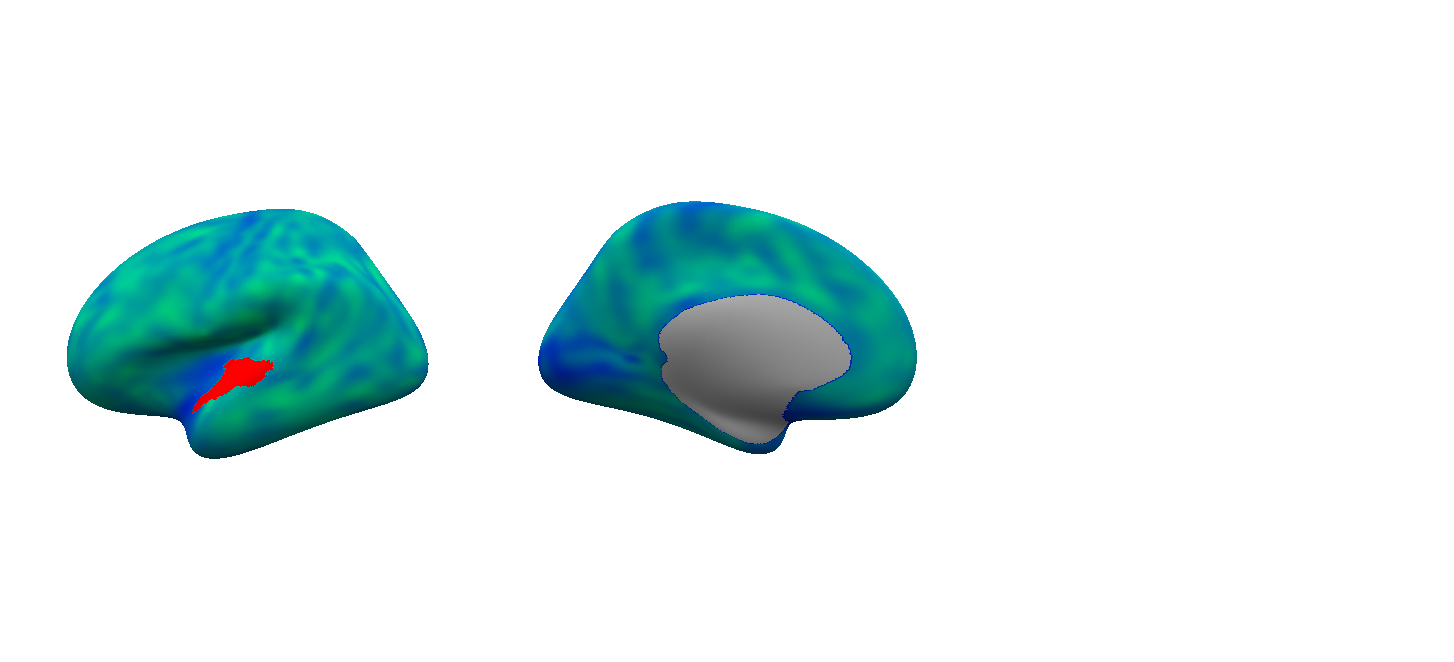

In [47]:
# plot feature and lesion before augmentation 
import matplotlib.pyplot as plt
cortex = MeldCohort().cortex_label
cortex_bin = np.zeros(len(labels_subj)).astype(bool)
cortex_bin[cortex] = 1

overlay = features_subj.copy()
overlay[labels_subj==1] = features_subj.max() + 0.5

# flat = nb.load(os.path.join("/rds/project/kw350/rds-kw350-meld/test_meld_v1.1.0/meld_data/meld_params", "fsaverage_sym", "surf", "lh.full.patch.flat.gii"))
# vertices, faces = flat.darrays[0].data, flat.darrays[1].data

vertices = cohort.surf['coords']
faces =  cohort.surf['faces']

msp.plot_surf(vertices,
              faces,
              overlay,  
              parcel=labels_subj,
              # flat_map=True,
              parcel_cmap={1.0:[1,0,0,0]},
              # filled_parcels=True,
              colorbar=False, rotate=[90, 270], base_size=10,
              cmap=newcmp,
            )

# plt.savefig(f'/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/23-02-10_images_MICCAI/{subject}_noaugment.png', transparent=True)


In [41]:
# initialise augmentation

from meld_graph.graph_tools import GraphTools

# apply transformation
augment_parameters= {
        "augment_lesion": {"p": 1},
        # "blur": {"p": 1},
        # "brightness": {"p": 1},
        # "contrast": {"p": 1},
        #"extend_lesion": {"p": 1},
        # "flipping": {"file": "data/flipping/flipping_ico7_3.npy", "p": 1},
        # "gamma": {"p": 1},
        # "low_res": {"p": 1},
        # "noise": {"p": 1},
        # "spinning": {"file": "data/spinning/spinning_ico7_10.npy", "p": 1},
        # "warping": {"file": "data/warping/warping_ico7_10.npy", "p": 1},
    }

# initialise icospheres
icos=IcoSpheres(conv_type='SpiralConv')
gt=GraphTools(icos)

augment = Augment(augment_parameters, gt)

DEBUG:meld_graph.icospheres:Using coord type pseudo


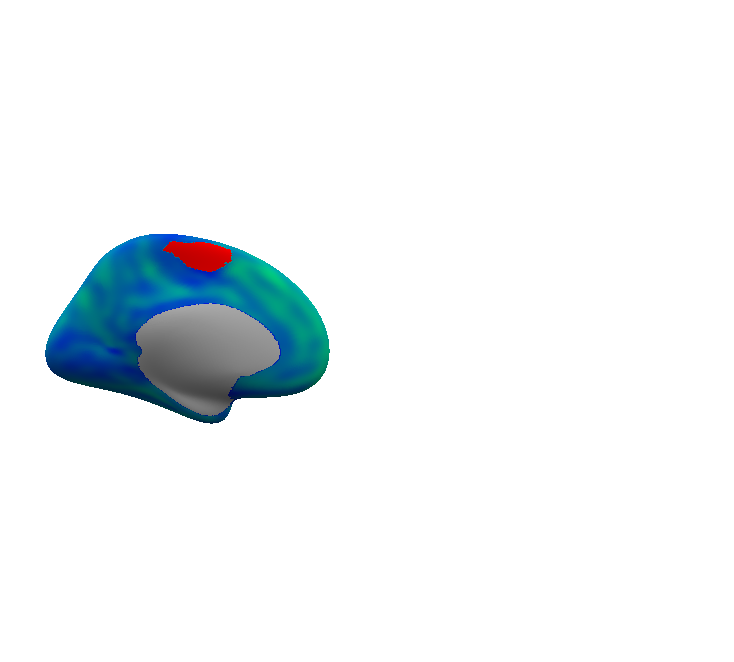

In [44]:
# apply augmentation

tdd = augment.apply(dataset.data_list[0])
augment_feature = tdd['features'][:,0]
augment_label =  tdd['labels'] 
augment_distance = tdd['distances'] 

overlay = augment_feature.copy()
overlay[augment_label==1]=augment_feature.max()+0.5

msp.plot_surf(vertices,
             faces,
              overlay,  
              parcel=augment_label,
              # flat_map=True,
              parcel_cmap={1.0:[1,0,0,0]},
              # filled_parcels=True,
              colorbar=False, rotate=[270], base_size=10,
              # mask=~cortex_bin, 
              # pvals=np.ones_like(cortex_bin),
              # vmin=np.percentile(augment_feature[cortex_bin], 1),
              # vmax=np.percentile(augment_feature[cortex_bin], 99),
              cmap=newcmp,
            )
plt.savefig(f'/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/23-02-10_images_MICCAI/{subject}_augmentlesion.png', transparent=True)

In [78]:
(~cortex_bin).sum()

0

### Plot synthetic

In [5]:
#load a subject
subject = 'MELD_H12_3T_C_0001'
       
data_parameters = data_parameters = {
    "augment_data": {
    },
    "combine_hemis": None,
    "dataset": "MELD_dataset_V6.csv",
    "features": [
        '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh'],
    "features_to_exclude": [],
    "features_to_replace_with_0": [],
    "fold_n": 0,
    "group": "control",
    "hdf5_file_root": "{site_code}_{group}_featurematrix_combat_6.hdf5",
    "icosphere_parameters": {"distance_type": "exact"},
    "lesion_bias": 0,
    "lobes": False,
    "number_of_folds": 5,
    "preprocessing_parameters": {
        "scaling": None,
        "zscore": "../data/feature_means.json",
    },
    "scanners": ["15T", "3T"],
    "site_codes": [
         "H4",
    ],
    "smooth_labels": True,
    "subject_features_to_exclude": [],
    "synthetic_data": {
        "bias": 1,
        "jitter_factor": 2,
        "n_subs": 1,
        "n_subtypes": 1,
        "proportion_features_abnormal": 0.9,
        "proportion_hemispheres_lesional": 0.5,
        "radius": 0.5,
        "run_synthetic": True,
        "smooth_lesion": False,
        "use_controls": True,
    },
}
cohort = MeldCohort(
            hdf5_file_root=data_parameters["hdf5_file_root"], dataset=data_parameters["dataset"]
        )
dataset = GraphDataset([subject], cohort, data_parameters, mode='test' , distance_maps=True)

features_subj = dataset.data_list[0]['features']
labels_subj =  dataset.data_list[0]['labels'] 
labels_smooth_subj =  dataset.data_list[0]['smooth_labels'] 
distance_subj = dataset.data_list[0]['distances'] 


DEBUG:meld_graph.icospheres:Using coord type pseudo
INFO:meld_graph.dataset:Loading and preprocessing test data
DEBUG:meld_graph.dataset:Combine hemis None
INFO:meld_graph.dataset:WARNING: Simulating 1 subjects using 1 controls
DEBUG:meld_classifier.meld_cohort:missing feature: .inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh set to zero
DEBUG:meld_classifier.meld_cohort:missing feature: .on_lh.lesion.mgh set to zero
INFO:meld_graph.data_preprocessing:Z-scoring data for MELD_H12_3T_C_0001
DEBUG:meld_classifier.meld_cohort:missing feature: .inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh set to zero
DEBUG:meld_classifier.meld_cohort:missing feature: .on_lh.lesion.mgh set to zero


dataset using distance_maps


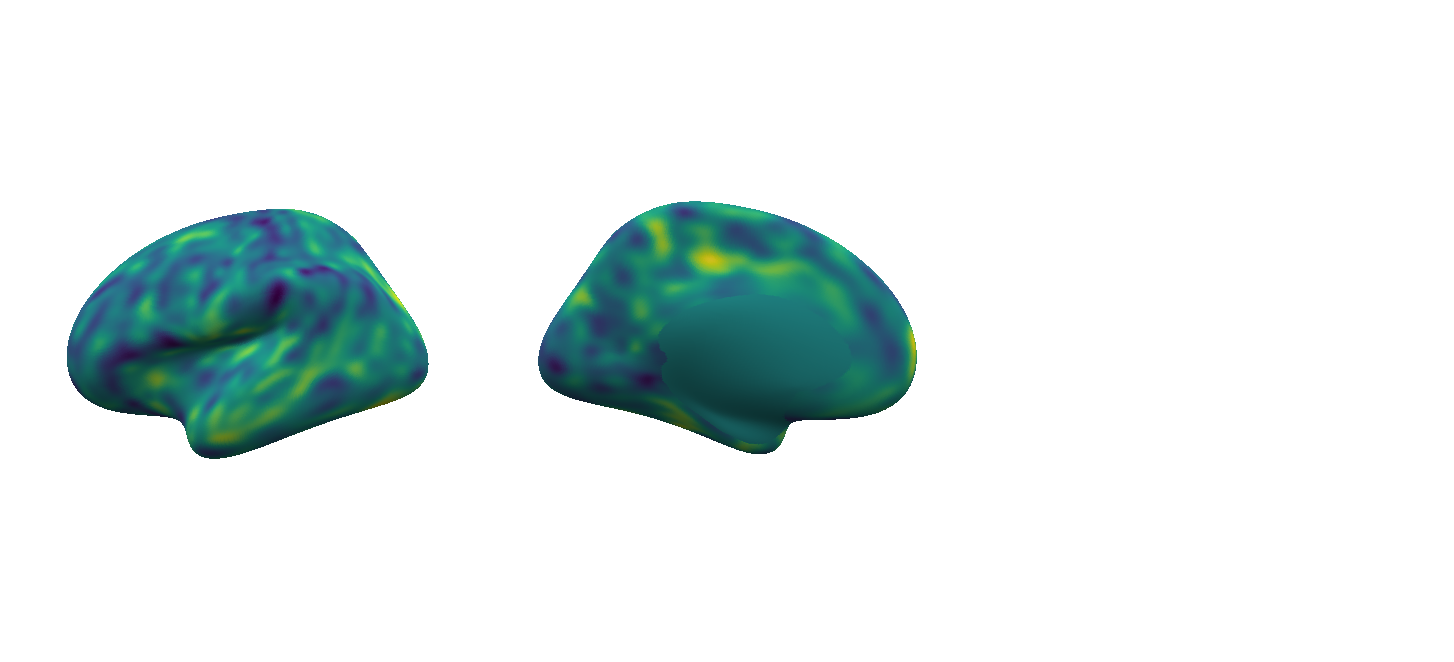

In [7]:
# plot feature and lesion for synthetic data
import matplotlib.pyplot as plt
cortex = MeldCohort().cortex_label
cortex_bin = np.zeros(len(labels_subj)).astype(bool)
cortex_bin[cortex] = 1

overlay = features_subj[:,0]
overlay[labels_subj==1] = features_subj.max() + 0.5

# flat = nb.load(os.path.join("/rds/project/kw350/rds-kw350-meld/test_meld_v1.1.0/meld_data/meld_params", "fsaverage_sym", "surf", "lh.full.patch.flat.gii"))
# vertices, faces = flat.darrays[0].data, flat.darrays[1].data

vertices = cohort.surf['coords']
faces =  cohort.surf['faces']

msp.plot_surf(vertices,
              faces,
              overlay,  
              parcel=labels_subj,
              # flat_map=True,
              parcel_cmap={1.0:[1,0,0,0]},
              # filled_parcels=True,
              colorbar=False, rotate=[90,270], base_size=10,
              cmap=newcmp,
            )

# plt.savefig(f'/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/23-02-10_images_MICCAI/synthetic_smalllesion.png', transparent=True)
